### MNE  
  
MNE is a python package for working with EEG/MEG data. Documentation can be found here: [MNE Documentation](https://mne.tools/stable/documentation/index.html#)  
  
I didn't know how to properly load my data with it before, but found a tutorial with my data on Kaggle: [Kaggle EEG with MNE](https://www.kaggle.com/code/kimbyungchun/preprocess-with-mne-for-human/notebook)  
  
This notebook follows that tutorial to load data and apply initial filters. Then I start experimenting with different MNE tools to get a more well-rounded understanding of how to use MNE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

##### Loading and Splitting Data

In [2]:
df = pd.read_csv('working_data.csv')

def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

##### Functions to Scale, Perform PCA, and Plot Signals

In [3]:
def load_eeg(data, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(data['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    return eeg, first_row
    
def load_sub_eeg(eeg, first_row):
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row:last_row]
    return sub_eeg.reset_index().drop(columns = 'index', inplace = True)

def scaler(eeg):
    electrodes = eeg.columns
    eeg_scaler = StandardScaler()
    eeg = eeg_scaler.fit_transform(eeg)
    eeg = pd.DataFrame(eeg, columns = electrodes)
    return eeg

### MNE

In [4]:
import mne

Loading a whole EEG

In [5]:
eeg_df = load_eeg(df, 200)[0]

Stores sampling frequency and determines highest frequency and lowest frequency based on that. Identifies the ECG channel (EKG in my data). Identifies the scalp electrode EEG channels (19 of them in my data). Allows for bad channels to be stored and held out of the data once detected.

In [6]:
info = mne.create_info(
    eeg_df.columns.to_list(),
    ch_types=(["eeg"]*(len(eeg_df.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Converts to array for MNE. Also rescales (doesn't standardize) the data to change the unit to volts

In [7]:
raw = mne.io.RawArray(
    eeg_df.to_numpy().T*1e-6,    # µV to V
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=10400
    Range : 0 ... 10399 =      0.000 ...    51.995 secs
Ready.


Plots EEG signals from 20s to 30s. Channel specified on the left. Time on the x axis.

Using matplotlib as 2D backend.


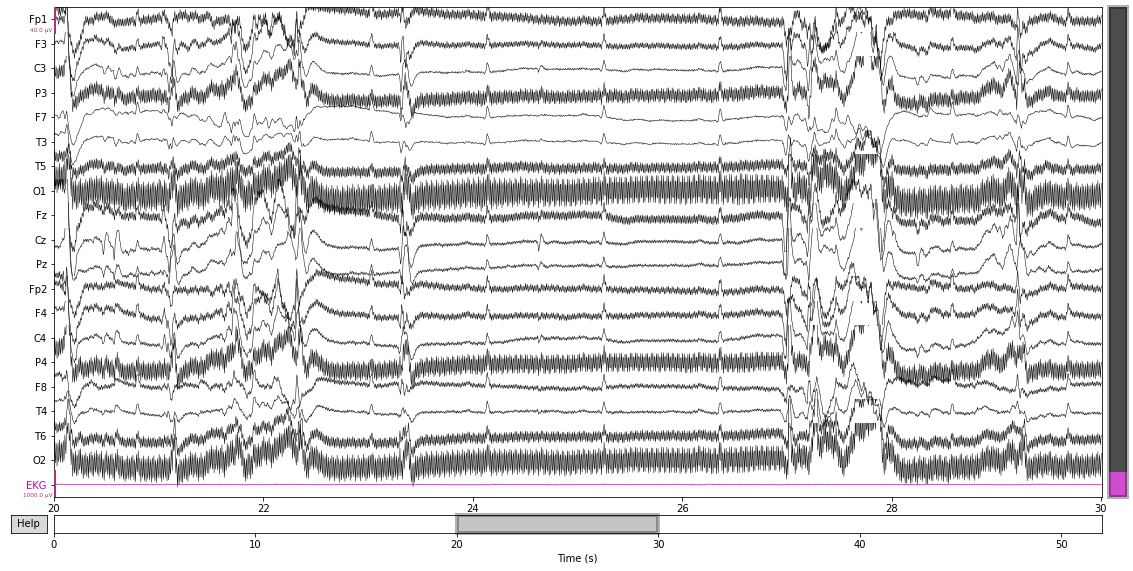

In [8]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw.plot(start=20, duration=10)
plt.show()

Plots the power spectrum before any denoising. Spike at 60 Hz is important. The notch filter is meant to handle that. Then smaller spike at about 80 Hz. Unsure what this is indicative of. Also, it looks that the data spikes again at 100 Hz, but because that's the cutoff for my frequency analysis, it's difficult to see.

Effective window size : 10.240 (s)


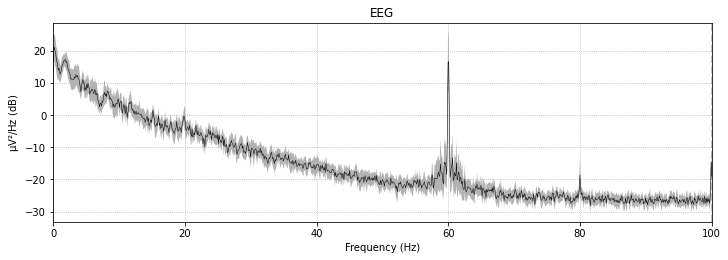

In [9]:
fig = raw.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

Filters applied to this EEG. A high pass filter (low frequency filter) of 1 Hz, a low pass filter (high frequency filter) of 70 Hz, and a notch filter at 60 Hz are applied to this EEG. These are based on recommendations found [here](https://www.learningeeg.com/montages-and-technical-components#filters).  
  
As the author of that article explains, low frequency filters are called high pass filters because they allow higher frequencies to pass through, and high frequency filters are called low pass filters because they allow lower frequencies to pass through.

This is a plot of the filtered EEG from 20s to 30s.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


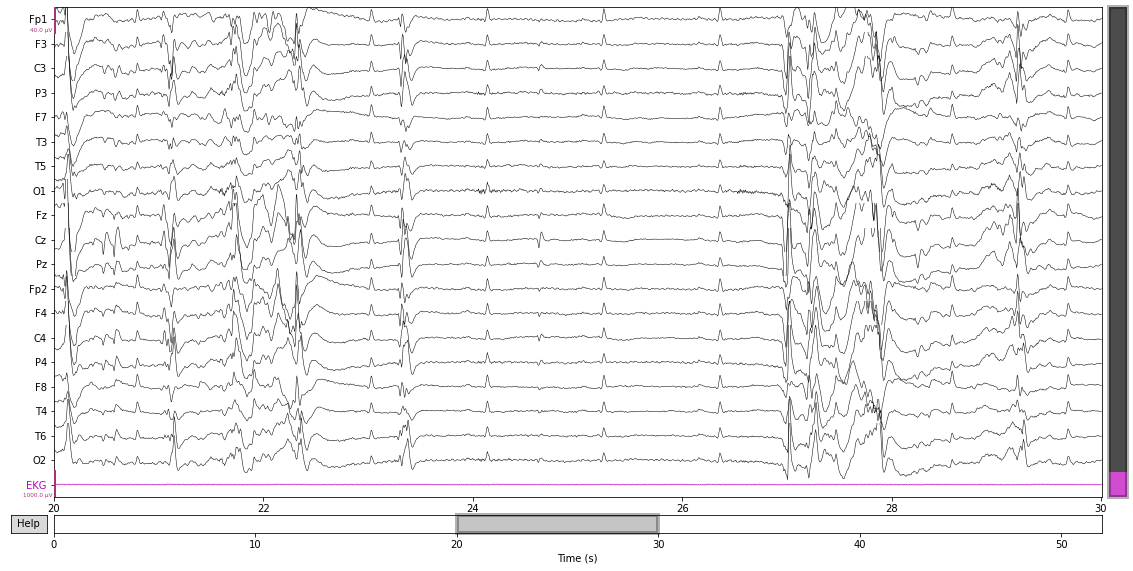

In [10]:
raw_filtered = raw.copy().filter(l_freq = 1, h_freq = 70,).notch_filter(60, picks = 'eeg')
raw_filtered.plot(start = 20, duration = 10)
plt.show()

This is a plot of the power spectrum of the filtered EEG. The 80 Hz spike is still there, but the 100 Hz spike isn't. The 60 Hz spike has inverted.

Effective window size : 10.240 (s)


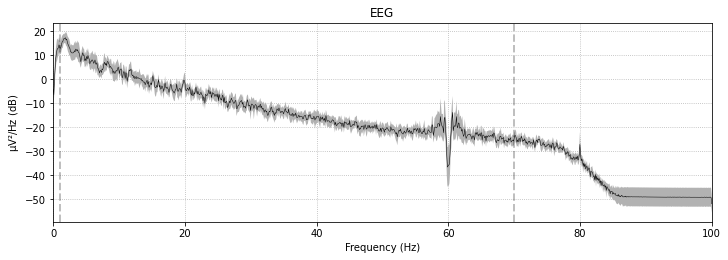

In [11]:
fig = raw_filtered.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

EEGs are often put in montages (sets of electrode chains which are sets of electrodes). The below code puts the filtered EEG into a [double banana bipolar montage](https://www.learningeeg.com/montages-and-technical-components#:~:text=bipolar%20montage%20II%3A%20types).  
  
This montage likely matches the montage used to generate the spectrograms provided with the data. The five groups for this montage are Left and Right Parasagittal, Left and Right Temporal (which would correspond with Lateral in this data), and Central which is either left out of the spectrograms or added to the other four groups somehow.  
  
These montages are different ways of grouping, visualizing, and analyzing EEG signals.

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=18, n_times=10400
    Range : 0 ... 10399 =      0.000 ...    51.995 secs
Ready.
Added the following bipolar channels:
Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, F8-T4, T4-T6, T6-O2, Fp1-F3, F3-C3, C3-P3, P3-O1, Fp2-F4, F4-C4, C4-P4, P4-O2, Fz-Cz, Cz-Pz


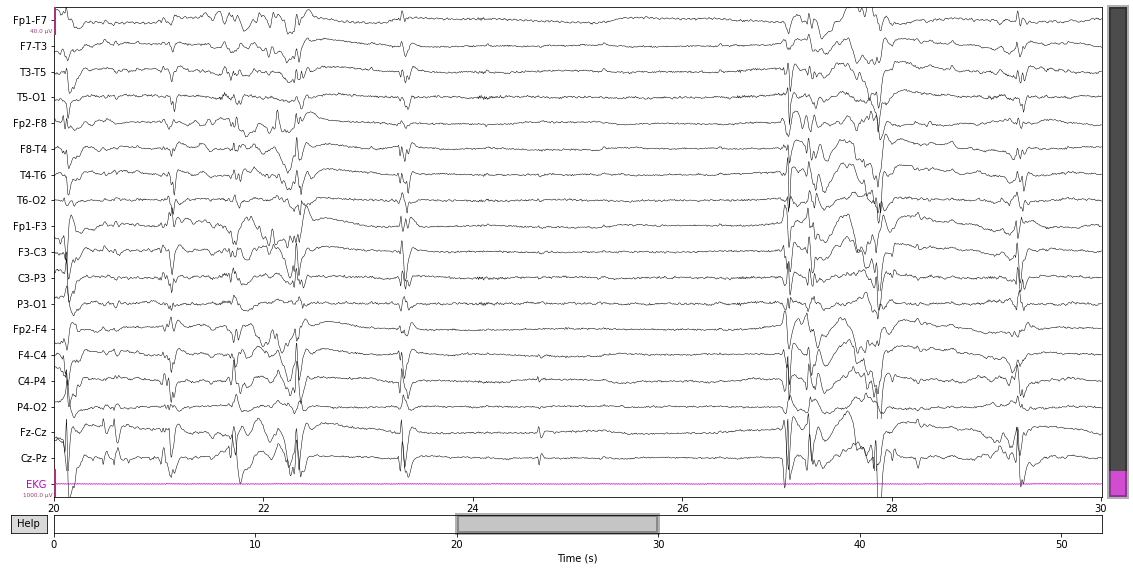

In [12]:
bipolar = [
    ['Fp1', 'F7'], ['F7', 'T3'], ['T3', 'T5'], ['T5', 'O1'],    # Left Lateral
    ['Fp2', 'F8'], ['F8', 'T4'], ['T4', 'T6'], ['T6', 'O2'],    # Right Lateral
    ['Fp1', 'F3'], ['F3', 'C3'], ['C3', 'P3'], ['P3', 'O1'],    # Left Parasagittal
    ['Fp2', 'F4'], ['F4', 'C4'], ['C4', 'P4'], ['P4', 'O2'],    # Right Parasagittal
    ['Fz', 'Cz'], ['Cz', 'Pz'],   # Central
]

anode, cathode = list(map(list,zip(*bipolar)))

raw_bip_ref = mne.set_bipolar_reference(raw_filtered, anode = anode, cathode = cathode)
raw_bip_ref.plot(start = 20, duration = 10)
plt.show()